In [40]:
import sys
sys.path.append('../') 

In [92]:

%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Params:

In [42]:
aggregate_by_state = False
outcome_type = 'deaths'

## Basic Data Visualization

In [58]:
# Just something to quickly summarize the number of cases and distributions each day

In [43]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../data/')
df = df.sort_values('#Deaths_3/29/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

In [148]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

Number of counties with non-zero cases
1953


(array([85., 59., 31., 28., 20., 13., 17., 13., 14.,  9.,  8.,  5., 10.,
        10.,  7.,  3.,  4.,  2.,  3.,  2.,  4.,  3.,  2.,  4.,  0.,  3.,
         6.,  1.,  1.,  2.,  1.,  3.,  3.,  2.,  0.,  1.,  0.,  1.,  0.,
         1.,  1.,  0.,  2.,  1.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,
         1.,  0.,  2.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.]),
 array([ 21. ,  30.6,  40.2,  49.8,  59.4,  69. ,  78.6,  88.2,  97.8,
        107.4, 117. , 126.6, 136.2, 145.8, 155.4, 165. , 174.6, 184.2,
        193.8, 203.4, 213. , 222.6, 232.2, 241.8, 251.4, 261. , 270.6,
        280.2, 289.8, 299.4, 309. , 318.6, 328.2, 337.8, 347.4, 357. ,
        366.6, 376.2, 385.8, 395.4, 405. , 414.6, 424.2, 433.8, 443.4,
        453. , 462.6, 472.2, 481.8, 491.4, 501. , 510.6, 520.2, 529.8,
        

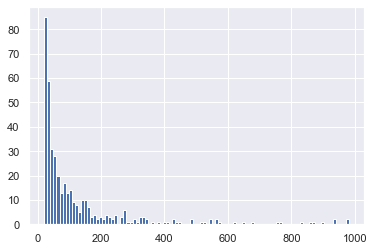

In [149]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [150]:
sum(max_cases)

136512

In [151]:
print(sum([v > 50 for v in max_cases]))


249


In [152]:
np.quantile(max_cases,.5)

1.0

Number of counties with non-zero deaths
365


(array([30.,  6.,  4.,  4.,  2.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  6.,  13.,  20.,  27.,  34.,  41.,  48.,  55.,  62.,  69.,  76.,
         83.,  90.,  97., 104., 111., 118., 125., 132., 139., 146., 153.,
        160., 167., 174., 181., 188., 195., 202., 209., 216.]),
 <a list of 30 Patch objects>)

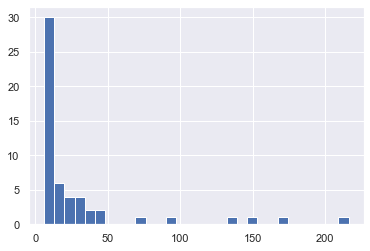

In [153]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

print('Number of counties with non-zero deaths')
print(sum([v >0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 5],bins=30)

In [154]:
sum(max_deaths)

2075

In [155]:
max(max_deaths)

216

In [156]:
np.quantile(max_deaths,.7)

0.0

### Clean data

In [44]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
max_deaths = [max(v) for v in df['deaths']]
df['max_deaths'] = max_deaths
df =  df[df['max_cases'] > 0]



## Predict data from model:

In [158]:
method_keys = []

In [91]:
# clear predictions
for m in method_keys:
    del df[m]
    

In [103]:
# Trains model on train_df and produces predictions for the final day for test_df and writes prediction
# to a new column for test_df 
fit_and_predict(df, method='exponential', outcome=outcome_type, mode='eval_mode',target_day=[1])
fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',target_day=[1])
# fit_and_predict(train_df, test_df,'shared_exponential', mode='eval_mode',demographic_vars=important_vars)
fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',demographic_vars=very_important_vars,target_day=[1])
fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=[],
                                     method='ensemble',target_day=[1])
# fit_and_predict(train_df, test_d f,method='exponential',mode='eval_mode',target_day = np.array([1,2]))

# Finds the names of all the methods
method_keys = [c for c in df if 'predicted' in c]
method_keys

Feature weights
log(deaths) : 0.9981505008513789
bias : 0.19806817090674161
Feature weights
PopulationDensityperSqMile2010 : 7.564484539346138e-06
PopulationEstimate2018 : 4.870246424704367e-08
#ICU_beds : -0.0004127820707512195
MedianAge2010 : 0.01887477603023386
Smokers_Percentage : -0.007293622992894233
DiabetesPercentage : 0.02302055984768759
HeartDiseaseMortality : 0.0014493648980887113
#Hospitals : 0.007608431024797937
log(deaths) : 0.9342734581903596
bias : -0.7356993261304152
Feature weights
log(deaths) : 0.9981505008513789
bias : 0.19806817090674161
Feature weights
log(deaths) : 0.9655859329391748
bias : 0.29005396981920656
Feature weights
log(deaths) : 0.9502200172608181
bias : 0.3378998196193722
Feature weights
log(deaths) : 0.9225917119833638
bias : 0.42318364462696306
Feature weights
log(deaths) : 0.9001884886739082
bias : 0.4755789604481969
Feature weights
log(deaths) : 0.8656056211882739
bias : 0.5606674381514144
Feature weights
log(deaths) : 0.830323777476037
bias : 0.6

['predicted_deaths_exponential_1',
 'predicted_deaths_shared_exponential_1',
 'predicted_deaths_shared_exponential_1_demographics',
 'predicted_deaths_ensemble_1']

In [118]:
for days_ahead in [1, 2, 3, 7]:
    for method in ['exponential', 'shared_exponential', 'ensemble']:
        fit_and_predict(df, method=method, outcome=outcome_type, mode='eval_mode',target_day=[days_ahead])
        if method == 'shared_exponential':
            fit_and_predict(df,method='shared_exponential', 
                            outcome=outcome_type, 
                            mode='eval_mode',
                            demographic_vars=very_important_vars,
                            target_day=[days_ahead])
method_keys = [c for c in df if 'predicted' in c]
geo = ['countyFIPS', 'CountyNamew/StateAbbrev']
#df_preds = df[method_keys + geo]
#df_preds.to_pickle("multi_day_1.pkl")

Feature weights
log(deaths) : 0.9981505008513789
bias : 0.19806817090674161
Feature weights
PopulationDensityperSqMile2010 : 7.564484539346138e-06
PopulationEstimate2018 : 4.870246424704367e-08
#ICU_beds : -0.0004127820707512195
MedianAge2010 : 0.01887477603023386
Smokers_Percentage : -0.007293622992894233
DiabetesPercentage : 0.02302055984768759
HeartDiseaseMortality : 0.0014493648980887113
#Hospitals : 0.007608431024797937
log(deaths) : 0.9342734581903596
bias : -0.7356993261304152
Feature weights
log(deaths) : 0.9981505008513789
bias : 0.19806817090674161
Feature weights
log(deaths) : 0.9655859329391748
bias : 0.29005396981920656
Feature weights
log(deaths) : 0.9502200172608181
bias : 0.3378998196193722
Feature weights
log(deaths) : 0.9225917119833638
bias : 0.42318364462696306
Feature weights
log(deaths) : 0.9001884886739082
bias : 0.4755789604481969
Feature weights
log(deaths) : 0.8656056211882739
bias : 0.5606674381514144
Feature weights
log(deaths) : 0.830323777476037
bias : 0.6

In [119]:
df_preds = df[method_keys + geo + ['deaths']]
df_preds.to_pickle("multi_day_2.pkl")

## Evaluate and visualize models

### Compute MSE and log MSE on relevant cases

In [188]:
# TODO: add average rank as metric

In [189]:
# Computes the mse in log space and non-log space for all columns

In [105]:
def l1(arr1,arr2):
    return sum([np.abs(a1-a2) for (a1,a2) in zip(arr1,arr2)])/len(arr1)
mse = sklearn.metrics.mean_squared_error
# Only evaluate points that exceed this number of deaths 
lower_threshold, upper_threshold = 10, 1000

In [121]:
# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][(outcome > lower_threshold) * (outcome < upper_threshold)]]
    print('Log scale MSE for '+key)
    print(mse(np.log(outcome[(outcome > lower_threshold) * (outcome < upper_threshold)] + 1),preds))

Log scale MSE for predicted_deaths_exponential_1
0.42459099381536586
Log scale MSE for predicted_deaths_shared_exponential_1
0.2290852360589301
Log scale MSE for predicted_deaths_shared_exponential_1_demographics
0.19731341161347526
Log scale MSE for predicted_deaths_ensemble_1
0.31845271147184584
Log scale MSE for predicted_deaths_exponential_2
0.47233850258011445
Log scale MSE for predicted_deaths_shared_exponential_2_demographics
0.1994066182782056
Log scale MSE for predicted_deaths_exponential_3
0.590807505263815
Log scale MSE for predicted_deaths_shared_exponential_3_demographics
0.3528300922010748
Log scale MSE for predicted_deaths_exponential_7
1.6315364766020761
Log scale MSE for predicted_deaths_shared_exponential_7_demographics
1.1780952208807745
Log scale MSE for predicted_deaths_shared_exponential_2
0.22952186939144725
Log scale MSE for predicted_deaths_ensemble_2
0.3061657657231749
Log scale MSE for predicted_deaths_shared_exponential_3
0.3616491552501405
Log scale MSE for

In [122]:
# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][outcome > lower_threshold]]
    print('Log scale l1 for '+key)
    print(l1(np.log(outcome[outcome > lower_threshold] + 1),preds))

Log scale l1 for predicted_deaths_exponential_1
0.33610136991229744
Log scale l1 for predicted_deaths_shared_exponential_1
0.25602843491606453
Log scale l1 for predicted_deaths_shared_exponential_1_demographics
0.22339941673572944
Log scale l1 for predicted_deaths_ensemble_1
0.2940994630511822
Log scale l1 for predicted_deaths_exponential_2
0.37962676161439735
Log scale l1 for predicted_deaths_shared_exponential_2_demographics
0.23690417104890463
Log scale l1 for predicted_deaths_exponential_3
0.5108177399988812
Log scale l1 for predicted_deaths_shared_exponential_3_demographics
0.4662803425972889
Log scale l1 for predicted_deaths_exponential_7
1.0056056042058654
Log scale l1 for predicted_deaths_shared_exponential_7_demographics
0.9558795628980049
Log scale l1 for predicted_deaths_shared_exponential_2
0.23637885721674406
Log scale l1 for predicted_deaths_ensemble_2
0.2512923747381703
Log scale l1 for predicted_deaths_shared_exponential_3
0.44306516734436213
Log scale l1 for predicted_

In [193]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw MSE for '+key)
    print(mse(outcome[outcome > lower_threshold],preds))

Raw MSE for predicted_deaths_exponential_3
6157.211937393064
Raw MSE for predicted_deaths_shared_exponential_3
867.4296738652763
Raw MSE for predicted_deaths_shared_exponential_3_demographics
413.99296154867636


In [120]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds))

Raw l1 for predicted_deaths_exponential_1
14.114369821156847
Raw l1 for predicted_deaths_shared_exponential_1
7.249422928302962
Raw l1 for predicted_deaths_shared_exponential_1_demographics
8.695674174569431
Raw l1 for predicted_deaths_ensemble_1
10.350624244858587
Raw l1 for predicted_deaths_exponential_2
17.241870635563824
Raw l1 for predicted_deaths_shared_exponential_2_demographics
11.710615048534473
Raw l1 for predicted_deaths_exponential_3
43.64532126326604
Raw l1 for predicted_deaths_shared_exponential_3_demographics
19.200346093716618
Raw l1 for predicted_deaths_exponential_7
54.47024004752492
Raw l1 for predicted_deaths_shared_exponential_7_demographics
20.898148866990205
Raw l1 for predicted_deaths_shared_exponential_2
12.738094982996326
Raw l1 for predicted_deaths_ensemble_2
7.60184416599453
Raw l1 for predicted_deaths_shared_exponential_3
20.528692946633196
Raw l1 for predicted_deaths_ensemble_3
14.854131955833525
Raw l1 for predicted_deaths_shared_exponential_7
42.33834942

### Plot residuals

In [195]:
# TODO: Create bounds automatically, create a plot function and call it instead of copying code, figure out way
# to plot more than two things at once cleanly

# Creates residual plots log scaled and raw
# We only look at cases with number of deaths greater than 5

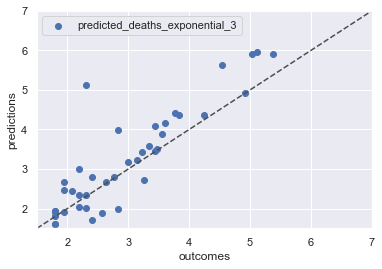

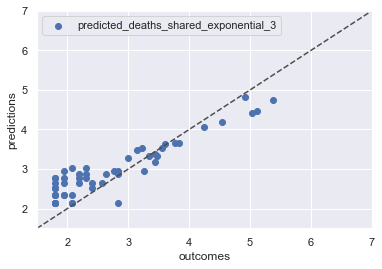

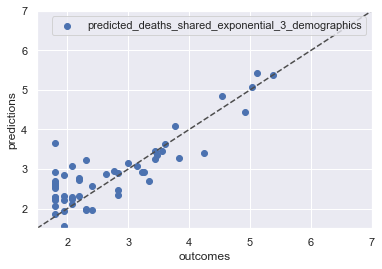

In [213]:
# Make log plots:
bounds = [1.5, 7]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=key)
    
    plt.xlabel('outcomes')
    plt.ylabel('predictions')
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

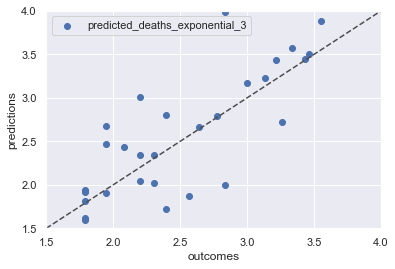

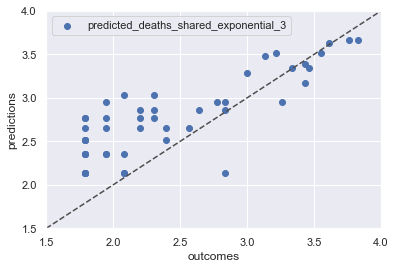

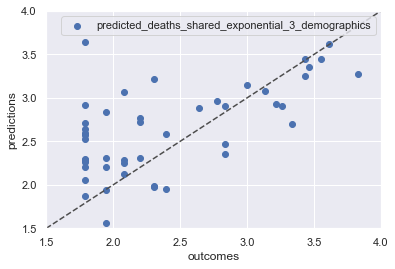

In [209]:
# Make log plots zoomed in for the counties that have a fewer number of deaths
bounds = [1.5, 4]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=key)

    plt.xlabel('outcomes')
    plt.ylabel('predictions')
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

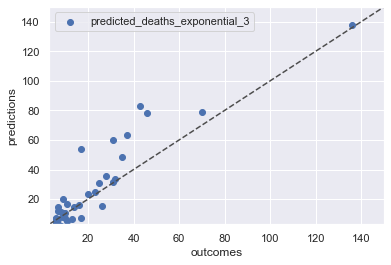

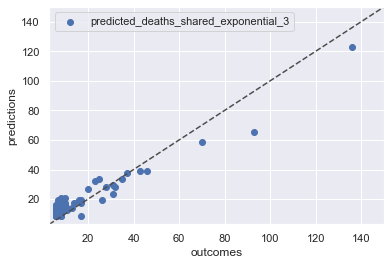

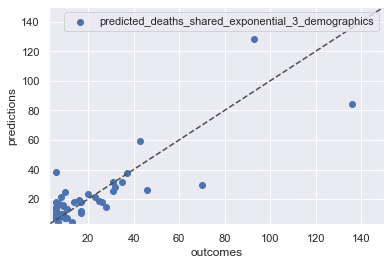

In [215]:
# Make non-log plots zoomed in for the counties that have a fewer number of deaths# We set bounds 
bounds = [3, 150]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > 5]]
    plt.scatter(outcome[outcome > 5],preds,label=key)

    plt.xlabel('outcomes')
    plt.ylabel('predictions')
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

### Graph Visualizations

In [199]:
# Here we visualize predictions on a per county level.
# The blue lines are the true number of deaths, and the dots are our predictions for each model for those days.

In [200]:
def method_name_to_pretty_name(key):
    # TODO: hacky, fix
    words = key.split('_')
    words2 = []
    for w in words:
        if not w.isnumeric():
            words2.append(w)
            
    model_name = words2[2:]
    return ' '.join(model_name)

In [201]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = 'deaths'
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    sns.lineplot(list(range(len(row[gold_key][start_point:]))),row[gold_key][start_point:], label=gold_key)
    
    

    for key in method_keys:
        preds = row[key]

        sns.scatterplot(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=method_name_to_pretty_name(key))
        
#         plt.scatter(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=key)
    
#     plt.legend()
#     plt.show()
#     sns.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

    

In [202]:
# feature_vals = {
# 'PopulationDensityperSqMile2010' : 1.1525491065255939e-05,
# "MedicareEnrollment,AgedTot2017" : -2.119520577282583e-06,
# 'PopulationEstimate2018' : 2.8898343032154275e-07,
# '#ICU_beds' : -0.000647030727828718,
# 'MedianAge2010' : 0.05032666600339253,
# 'Smokers_Percentage' : -0.013410742818946319,
# 'DiabetesPercentage' : 0.04395318355581005,
# 'HeartDiseaseMortality' : 0.0015473771787186525,
# '#Hospitals': 0.019248102357644396,
# 'log(deaths)' : 0.8805209010821442,
# 'bias' : -1.871552103871495
# }

Queens in NY


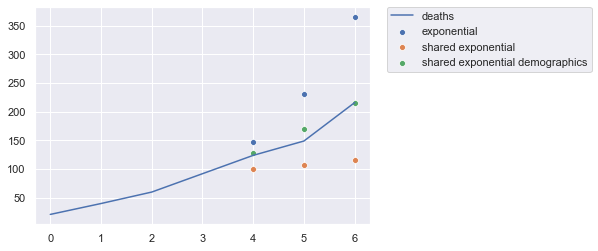

PopulationDensityperSqMile2010: 20553.6
PopulationEstimate2018: 2278906.0
#ICU_beds: 129
MedianAge2010: 37.2
Smokers_Percentage: 12.42777748
DiabetesPercentage: 10.2
HeartDiseaseMortality: 180.0
#Hospitals: 6


Kings in NY


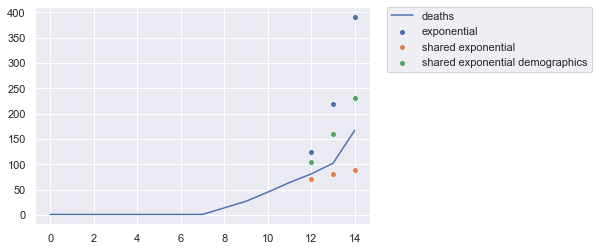

PopulationDensityperSqMile2010: 35369.2
PopulationEstimate2018: 2582830.0
#ICU_beds: 318
MedianAge2010: 34.1
Smokers_Percentage: 13.840801998
DiabetesPercentage: 9.7
HeartDiseaseMortality: 195.8
#Hospitals: 12


Bronx in NY


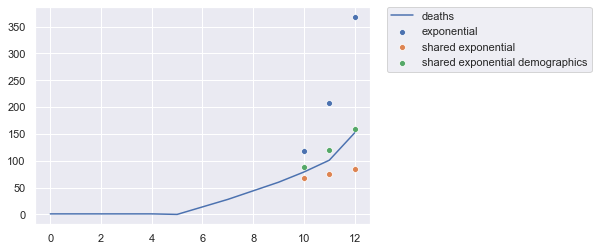

PopulationDensityperSqMile2010: 32903.3
PopulationEstimate2018: 1432132.0
#ICU_beds: 270
MedianAge2010: 32.8
Smokers_Percentage: 15.921168722
DiabetesPercentage: 12.3
HeartDiseaseMortality: 201.3
#Hospitals: 6


King in WA


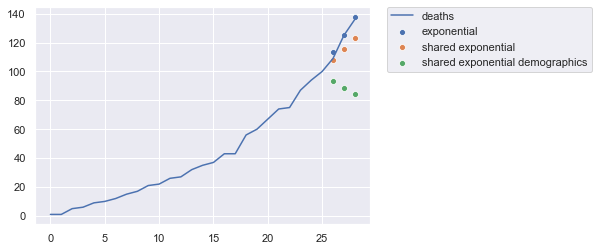

PopulationDensityperSqMile2010: 912.9
PopulationEstimate2018: 2233163.0
#ICU_beds: 450
MedianAge2010: 37.1
Smokers_Percentage: 8.8150454593
DiabetesPercentage: 7.1
HeartDiseaseMortality: 118.9
#Hospitals: 17


New York in NY


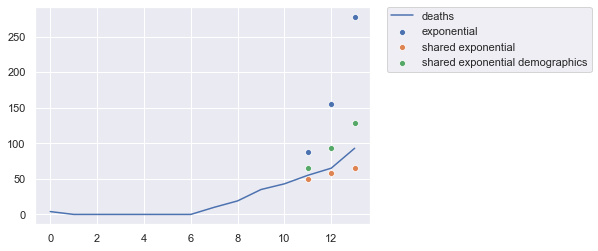

PopulationDensityperSqMile2010: 69468.4
PopulationEstimate2018: 1628701.0
#ICU_beds: 761
MedianAge2010: 36.4
Smokers_Percentage: 12.41823421
DiabetesPercentage: 6.5
HeartDiseaseMortality: 143.5
#Hospitals: 12


Orleans in LA


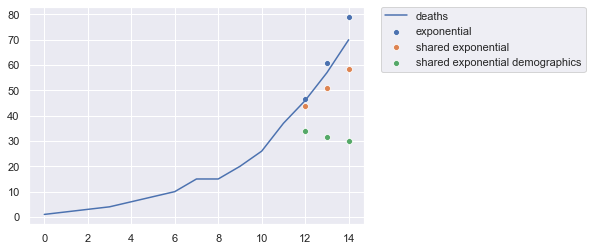

PopulationDensityperSqMile2010: 2029.4
PopulationEstimate2018: 391006.0
#ICU_beds: 111
MedianAge2010: 34.6
Smokers_Percentage: 22.609624129
DiabetesPercentage: 10.3
HeartDiseaseMortality: 189.7
#Hospitals: 5


Wayne in MI


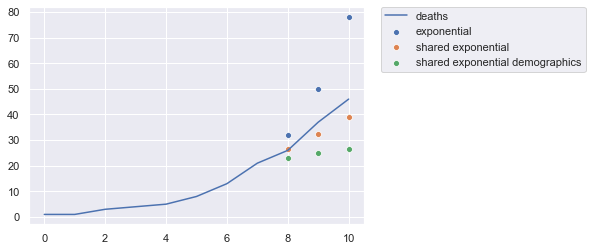

PopulationDensityperSqMile2010: 2974.4
PopulationEstimate2018: 1753893.0
#ICU_beds: 586
MedianAge2010: 37.3
Smokers_Percentage: 21.055529729
DiabetesPercentage: 10.3
HeartDiseaseMortality: 259.2
#Hospitals: 14


Richmond in NY


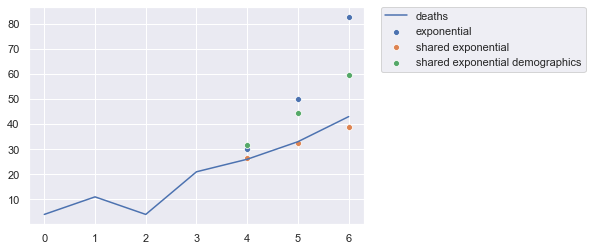

PopulationDensityperSqMile2010: 8030.3
PopulationEstimate2018: 476179.0
#ICU_beds: 114
MedianAge2010: 38.4
Smokers_Percentage: 15.373417772
DiabetesPercentage: 9.6
HeartDiseaseMortality: 239.6
#Hospitals: 2


Suffolk in NY


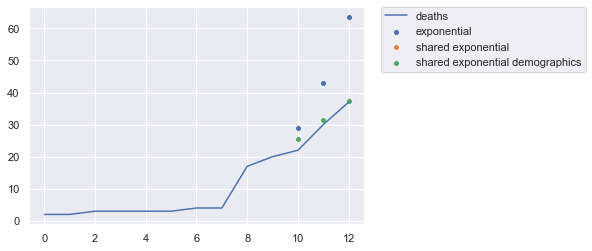

PopulationDensityperSqMile2010: 1637.4
PopulationEstimate2018: 1481093.0
#ICU_beds: 281
MedianAge2010: 39.8
Smokers_Percentage: 12.625481467
DiabetesPercentage: 6.8
HeartDiseaseMortality: 181.8
#Hospitals: 10


Nassau in NY


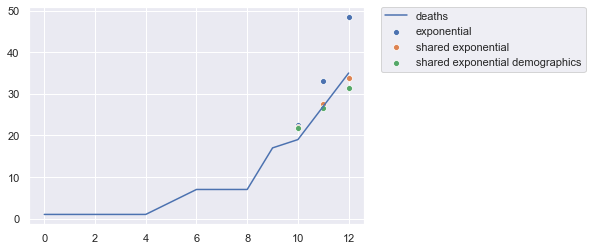

PopulationDensityperSqMile2010: 4704.8
PopulationEstimate2018: 1358343.0
#ICU_beds: 461
MedianAge2010: 41.1
Smokers_Percentage: 11.225364644
DiabetesPercentage: 7.2
HeartDiseaseMortality: 188.2
#Hospitals: 10


Los Angeles in CA


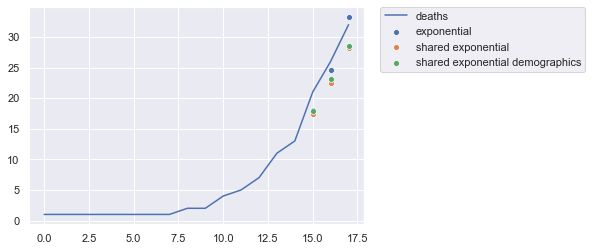

PopulationDensityperSqMile2010: 2419.6
PopulationEstimate2018: 10105518.0
#ICU_beds: 2126
MedianAge2010: 34.8
Smokers_Percentage: 10.847678109
DiabetesPercentage: 8.1
HeartDiseaseMortality: 150.8
#Hospitals: 76


Oakland in MI


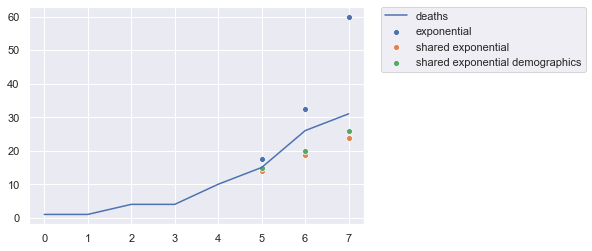

PopulationDensityperSqMile2010: 1385.8
PopulationEstimate2018: 1259201.0
#ICU_beds: 409
MedianAge2010: 40.2
Smokers_Percentage: 12.308266081
DiabetesPercentage: 7.7
HeartDiseaseMortality: 181.4
#Hospitals: 12


Bergen in NJ


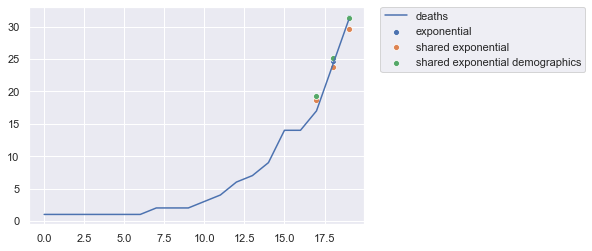

PopulationDensityperSqMile2010: 3884.5
PopulationEstimate2018: 936692.0
#ICU_beds: 147
MedianAge2010: 41.1
Smokers_Percentage: 11.410986988
DiabetesPercentage: 6.8
HeartDiseaseMortality: 140.1
#Hospitals: 6


Cook in IL


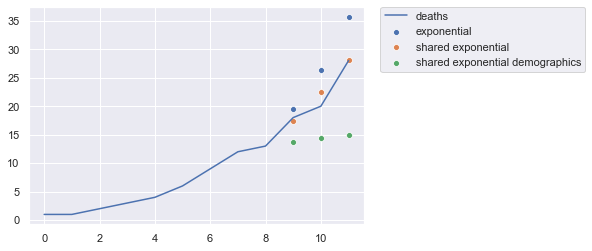

PopulationDensityperSqMile2010: 5495.1
PopulationEstimate2018: 5180493.0
#ICU_beds: 1606
MedianAge2010: 35.3
Smokers_Percentage: 13.776183162
DiabetesPercentage: 9
HeartDiseaseMortality: 175.1
#Hospitals: 46


Jefferson in LA


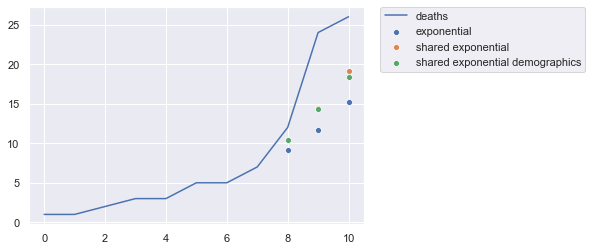

PopulationDensityperSqMile2010: 1463.1
PopulationEstimate2018: 434051.0
#ICU_beds: 215
MedianAge2010: 38.4
Smokers_Percentage: 18.743669593
DiabetesPercentage: 12.7
HeartDiseaseMortality: 178.7
#Hospitals: 5


Santa Clara in CA


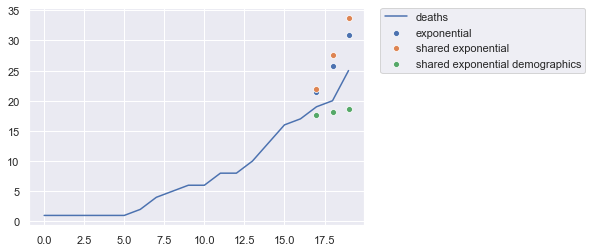

PopulationDensityperSqMile2010: 1381.0
PopulationEstimate2018: 1937570.0
#ICU_beds: 313
MedianAge2010: 36.2
Smokers_Percentage: 8.2690140125
DiabetesPercentage: 7.3
HeartDiseaseMortality: 104.2
#Hospitals: 9


Snohomish in WA


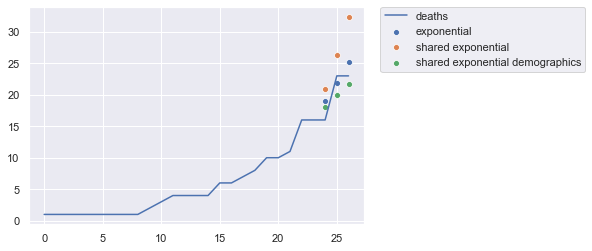

PopulationDensityperSqMile2010: 341.8
PopulationEstimate2018: 814901.0
#ICU_beds: 72
MedianAge2010: 37.1
Smokers_Percentage: 12.962308599
DiabetesPercentage: 7.7
HeartDiseaseMortality: 131.9
#Hospitals: 4


Fairfield in CT


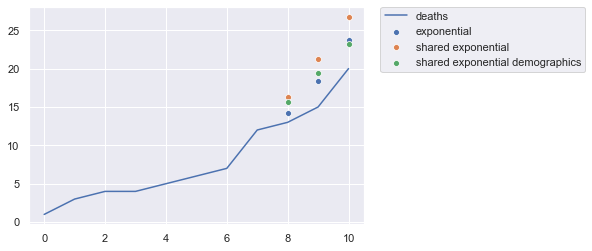

PopulationDensityperSqMile2010: 1467.2
PopulationEstimate2018: 943823.0
#ICU_beds: 173
MedianAge2010: 39.5
Smokers_Percentage: 10.157896011
DiabetesPercentage: 6.4
HeartDiseaseMortality: 137.1
#Hospitals: 6


Macomb in MI


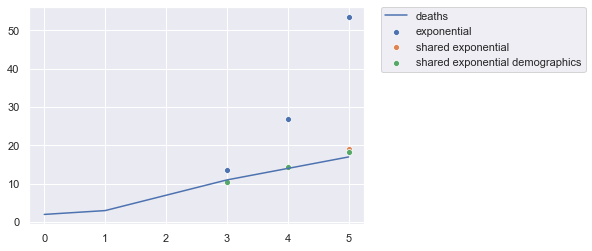

PopulationDensityperSqMile2010: 1754.9
PopulationEstimate2018: 874759.0
#ICU_beds: 122
MedianAge2010: 39.9
Smokers_Percentage: 18.558096157
DiabetesPercentage: 9.5
HeartDiseaseMortality: 196.6
#Hospitals: 4


Dougherty in GA


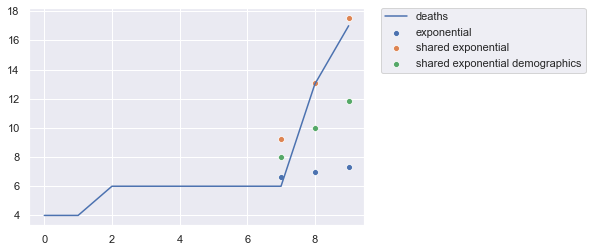

PopulationDensityperSqMile2010: 287.7
PopulationEstimate2018: 91243.0
#ICU_beds: 50
MedianAge2010: 33.2
Smokers_Percentage: 21.607553194
DiabetesPercentage: 13.8
HeartDiseaseMortality: 178.8
#Hospitals: 1


Middlesex in NJ


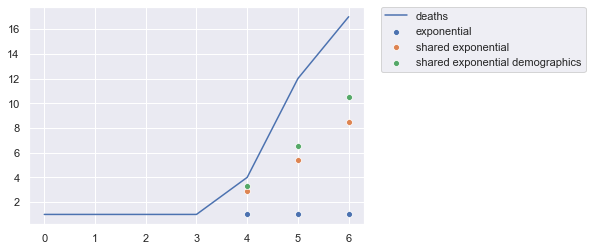

PopulationDensityperSqMile2010: 2621.6
PopulationEstimate2018: 829685.0
#ICU_beds: 185
MedianAge2010: 37.2
Smokers_Percentage: 10.970467888
DiabetesPercentage: 9.7
HeartDiseaseMortality: 154.3
#Hospitals: 5


Essex in NJ


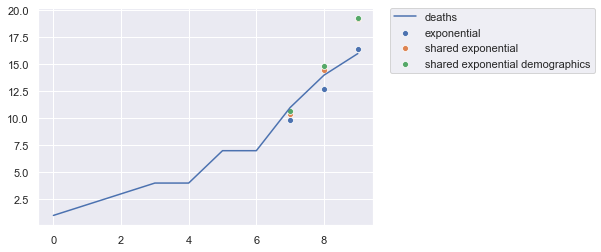

PopulationDensityperSqMile2010: 6211.5
PopulationEstimate2018: 799767.0
#ICU_beds: 267
MedianAge2010: 36.4
Smokers_Percentage: 14.235389268
DiabetesPercentage: 9.9
HeartDiseaseMortality: 169.8
#Hospitals: 7


Clark in NV


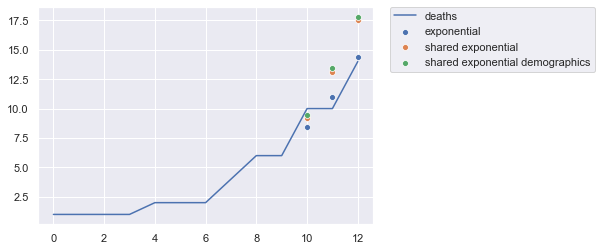

PopulationDensityperSqMile2010: 247.3
PopulationEstimate2018: 2231647.0
#ICU_beds: 535
MedianAge2010: 35.5
Smokers_Percentage: 16.979704666
DiabetesPercentage: 10
HeartDiseaseMortality: 204.3
#Hospitals: 19


Fulton in GA


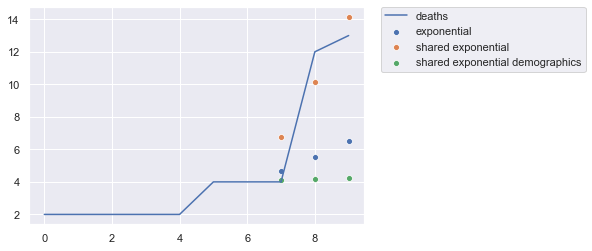

PopulationDensityperSqMile2010: 1748.1
PopulationEstimate2018: 1050114.0
#ICU_beds: 538
MedianAge2010: 34.2
Smokers_Percentage: 14.925509463
DiabetesPercentage: 8.3
HeartDiseaseMortality: 157.6
#Hospitals: 7


Morris in NJ


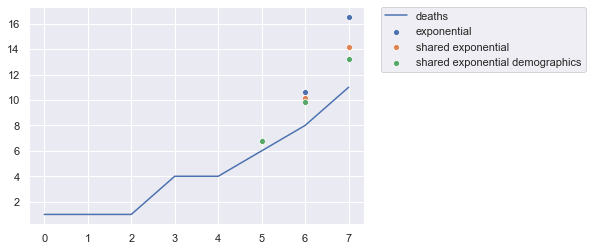

PopulationDensityperSqMile2010: 1069.8
PopulationEstimate2018: 494228.0
#ICU_beds: 91
MedianAge2010: 41.3
Smokers_Percentage: 12.111935176
DiabetesPercentage: 6.3
HeartDiseaseMortality: 143.5
#Hospitals: 3


Broward in FL


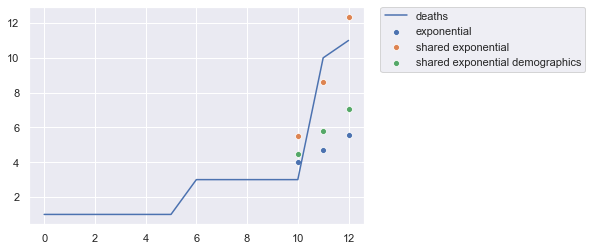

PopulationDensityperSqMile2010: 1444.9
PopulationEstimate2018: 1951260.0
#ICU_beds: 587
MedianAge2010: 39.7
Smokers_Percentage: 14.593792551
DiabetesPercentage: 8.1
HeartDiseaseMortality: 146.9
#Hospitals: 14




In [204]:
df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    row = df.iloc[i]
    # If number of deaths greater than 10
    if max(row['deaths']) > 10:
        print(row['CountyName']+' in '+row['StateNameAbbreviation'])
        plot_prediction(row)
        for v in very_important_vars:
            print(v+ ': '+str(row[v])) #+';\t contrib: '+ str(feature_vals[v]*float(row[v])))
        print('\n')